# Preparing WBC Data and NYT LM 

Python 2.4

In [2]:
import pandas as pd
import xml.etree.ElementTree as ET
import os, sys
import numpy as np
import pandas as pd
import re
import random
import nltk
tokenizer = nltk.tokenize.treebank.TreebankWordTokenizer()

# Sklearn
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [3]:
os.chdir('../python')

In [4]:
import semanticDensity as sd

Read in Sample of News Articles

In [95]:
articleLoc = '/Volumes/Seagate Backup Plus Drive/NYT_GerberSample/news_documents.xml'

In [98]:
def parse_xml(file, key, columnTitles):
    #create empty dictionary
    productRow = {}

    #create list that will store the single dataframe rows
    rows = []

    #read in file noting when tags begin or end
    for event, element in ET.iterparse(file, events=("start", "end")):

    #get current product
        if event == "start" and element.tag == key:
            productRow = {} # dictionary on current row

        for title in columnTitles: #for each tag in the xml
            if event == "end" and element.tag == title: #if a <\TITLE> is present, then add
                productRow[title] = element.text #add to dictionary

    #done adding values - now append
        if event == "end" and element.tag == columnTitles[len(columnTitles)-1]:
            rows.append(productRow) #append to list of rows

    #create pandas dataframe with column names of tags
    frame = pd.DataFrame.from_records(rows, columns=columnTitles)
    return frame


In [99]:
data = parse_xml(articleLoc, 'doc', ['id','t','d','c'])

In [100]:
data.columns = ['id','title','date','content']

### Build Metadata File for WBC Sermons

In [7]:
dataloc = '/Users/hopeemac/Documents/Code/GIT/DSI_Religion/data_dsicap/WBC/raw/'

In [8]:
files = os.listdir(dataloc)

In [9]:
files = [file for file in files if '.txt' in file]

In [10]:
fileData = pd.DataFrame(files, columns = ['fileName'])

In [11]:
temp = [file.split('_')[2][0:8] for file in files]

In [12]:
fileData['date'] = temp

In [13]:
fileData[0:5]

,fileName,date
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715


Set up Protest Data (Random for now)

In [14]:
protests = ([1]*48 + [0]*(len(fileData)-48))

In [15]:
random.shuffle(protests)

In [16]:
fileData['protest'] = protests

In [110]:
tokenLists = {file: tokenize(dataloc, file) for file in fileData.fileName}

In [111]:
tokenLists = {file: clean_text(tokenLists[file]) for file in fileData.fileName}

In [112]:
tokenLists[files[0]]

['sunday',
 ',',
 'may',
 'NUM',
 ',',
 'NUM',
 'page',
 'NUM',
 'sermon',
 'outline',
 '``',
 'away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 'earth',
 ';',
 'for',
 'it',
 'is',
 'not',
 'fit',
 'that',
 'he',
 'should',
 'live.',
 "''",
 'acts',
 'NUM:NUM.',
 'according',
 'to',
 'friday',
 'c-j',
 'paper',
 ',',
 'some',
 'are',
 'talking',
 'about',
 'a',
 'petition',
 'demanding',
 'phelps',
 'be',
 'ousted',
 'from',
 'kansas.',
 'a',
 'sort',
 'of',
 'persona',
 'non',
 'grata',
 ',',
 'like',
 'they',
 'did',
 'in',
 'canada',
 '\xad',
 'and',
 'everywhere',
 'else',
 'if',
 'they',
 'get',
 'the',
 'chance.',
 'beloved',
 ',',
 'we',
 "'re",
 'in',
 'good',
 'company',
 ';',
 'this',
 'is',
 'more',
 'evidence',
 'our',
 'ministry',
 'is',
 'of',
 'god',
 'and',
 'our',
 'calling',
 'and',
 'election',
 'is',
 'sure.',
 'NUM',
 'pet.',
 'NUM:NUM.',
 'the',
 'mob',
 'said',
 'of',
 'paul',
 ':',
 '``',
 'away',
 'with',
 'such',
 'a',
 'fellow',
 'from',
 'the',
 

In [28]:
counts = [count_words(tokenLists[key]) for key in tokenLists.keys()]

In [29]:
protest = [count_specific_words(tokenLists[key], 'protest') for key in tokenLists.keys()]

In [30]:
god = [count_specific_words(tokenLists[key], 'god') for key in tokenLists.keys()]

In [31]:
fileData['wordcount'] = counts

In [32]:
fileData['protest_word'] = protest

In [33]:
fileData['god'] = god

In [34]:
fileData[0:10]

,fileName,date,protest,wordcount,protest_word,god
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,0,5770,0,72
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0,4586,0,26
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701,0,3487,0,10
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708,0,5642,0,32
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715,0,3171,0,19
5,WestboroBaptist_Sermon_20070722.pdf.txt,20070722,0,3459,0,18
6,WestboroBaptist_Sermon_20070729.pdf.txt,20070729,0,3285,0,35
7,WestboroBaptist_Sermon_20070805.pdf.txt,20070805,0,3633,0,36
8,WestboroBaptist_Sermon_20070812.pdf.txt,20070812,0,3407,0,35
9,WestboroBaptist_Sermon_20070819.pdf.txt,20070819,0,3342,0,8


## Semantic Density Signal w/ News

In [101]:
data[0:10]

,id,title,date,content
0,AFP_ENG_20041001.0001,"URGENT US forces enter Samarra, seize city hal...","BAGHDAD, Oct 1 (AFP).",US and Iraqi forces poured into central Samarr...
1,AFP_ENG_20041001.0002,China's West to East pipeline carries first ga...,"SHANGHAI, Oct 1 (AFP).",The eastern economic hub of Shanghai received ...
2,AFP_ENG_20041001.0003,Japan lobbies US for pullout by majors from Ch...,"TOKYO, Oct 1 (AFP).",The Japanese government lobbied the US governm...
3,AFP_ENG_20041001.0004,"US forces enter Samarra, seize city hall, poli...","BAGHDAD, Oct 1 (AFP).",US and Iraqi forces poured into central Samarr...
4,AFP_ENG_20041001.0005,Millions of Chinese on the move as week-long h...,"BEIJING, Oct 1 (AFP).",Millions of Chinese were on the move Friday at...
5,AFP_ENG_20041001.0006,South Korea's biggest lender to post huge prof...,"SEOUL, Oct 1 (AFP).","Kookmin Bank, South Korea's biggest retail ban..."
6,AFP_ENG_20041001.0007,Michelin signs supply deal with China's Baoshan.,"SHANGHAI, Oct 1 (AFP).",Global tyre manufacturer Michelin has signed a...
7,AFP_ENG_20041001.0008,"Bush, Kerry, clash on Iraq in first debate.","CORAL GABLES, Florida, Sept 30 (AFP).",Senator John Kerry charged Thursday that Presi...
8,AFP_ENG_20041001.0009,"""We won"" the debate, Democrats crow, ""No, we d...","CORAL GABLES, Florida, Oct 1 (AFP).",Jubilant Democrats boasted late Thursday they ...
9,AFP_ENG_20041001.0010,Indonesia swears in new parliament.,"JAKARTA, Oct 1 (AFP).",Indonesia took a confident step towards full d...


Convert News Articles to Tokens and Pre-Process

In [104]:
newsTokenLists = {data.loc[rowID,'id']: tokenizer.tokenize(data.loc[rowID,'content']) for rowID in range(0,len(data))}

In [106]:
newsTokenLists = {data.loc[rowID,'id']: clean_text(newsTokenLists[data.loc[rowID,'id']]) for rowID in range(0,len(data))}

In [107]:
#Get word coCo for News Articles
CoCo, TF, docTF = sd.coOccurence(newsTokenLists,k=2)

In [108]:
TF['god']

32

In [109]:
#Get DSM for News Articles
DSM=sd.DSM(CoCo,100)
#pickle.dump(DSM,open(folderPath+'/testDSM.pickle', 'wb') )

In [ ]:
sampleFile = ''

In [149]:
# For a single WBC document, get the Context Vectors for Target Word
CVDict=contextVectors(tokenLists[files[0]], DSM, ['god'], 2)


# Get Cosine Similarity betwen target word vector in DSM and each context


# Get average CoSim for all context == New Signal


In [156]:
CVDict['god'][3]

{0: 6.3293181405440784,
 1: 3.8104580986275089,
 2: 1.4601994754413039,
 3: -0.49555745786210059,
 4: 2.3141321594636293,
 5: 0.48195377393478678,
 6: -0.84795110931940754,
 7: 0.55783261635080383,
 8: 1.0694903887349028,
 9: 0.73538719678735609,
 10: 1.8881471594987862,
 11: 0.32409265128215847,
 12: 0.90174539702424061,
 13: 1.8719298753212337,
 14: 1.3522708748805181,
 15: 1.4541632890122618,
 16: 0.60618415923926039,
 17: 0.42275572978924908,
 18: 1.1473074853590444,
 19: 0.80118185977204992,
 20: 0.49847081032803342,
 21: 1.1391957437786968,
 22: 0.5236871884019606,
 23: 0.89737786022235333,
 24: 1.9786081048349589,
 25: 0.17189646675120673,
 26: 0.69944116146290225,
 27: 0.33263740954422377,
 28: 0.78757581715426972,
 29: 1.5412756355651842,
 30: 0.43166165522382915,
 31: 1.1530235215494187,
 32: 0.86465336093104295,
 33: 0.6409580443119266,
 34: 0.97846553542161097,
 35: 0.78342292078357567,
 36: 1.0828785273760104,
 37: 1.1787168066766596,
 38: 1.0807085870879516,
 39: 0.665981

In [ ]:
#Run cosine sim
cosineSimilarity=sd.averageCosine(CVDict,subFileList,wordList,simCount)
avgSD=np.mean([x[1] for x in cosineSimilarity])
#pd.DataFrame(cosineSimilarity).to_csv(folderPath+'/contextVectors.csv')

In [148]:
#Define function to create context vectors
def contextVectors(tokenList,dsm,wordlist,k):
    
    #Define coOccurence dict
    cvDict={}

    for i in range(len(tokenList)):
        targetword=tokenList[i] # Changed window to targetword for more clarity
        
        if targetword in wordlist: 
            #Adjust window to contain words k in front or k behind
            lowerBound=max(0,i-k)
            upperBound=min(len(tokenList),i+k) # FIXED BUG HERE, SAME AS ABOVE ADD [FILENAME]
            cvList=tokenList[lowerBound:i]+tokenList[i+1:upperBound+1]
    

            if targetword not in cvDict.keys():
                cvDict[targetword]={}

            #Create context vector            
            contextVector={}

            for word in cvList:
                if word in dsm.keys():
                    
                    for key in dsm[word].keys(): # Need to Catch for Words in Window, but not in DSM                 
                        #Update context vector
                        try:
                            contextVector[key]=contextVector[key]+dsm[word][key]
                        except: # What is this except for?
                            contextVector[key]=dsm[word][key]
                else:
                    for i in range(0,len(dsm[list(dsm.keys())[0]])):
                        contextVector[i] = 1

            #Add context vector to cvDict
            cvIndex=len(cvDict[targetword])+1
            cvDict[targetword][cvIndex]=contextVector
    
    #Return context vector dictionary
    return(cvDict)

## Methods

In [19]:
def tokenize(path2File, file):
    tokens={}
    # print(path2File+file)
    #Clean raw text into token list
    rawText=open(path2File+file).read()

    #Update for encoding issues            
    # rawText=unicode(rawText, "utf-8", errors="ignore")
    
    #Tokenize
    tokenList=tokenizer.tokenize(rawText)
    
    return tokenList

In [20]:
#Define tokenize function
def clean_text(tokenList):
    
    #Convert all text to lower case
    tokenList=[word.lower() for word in tokenList]

    #Remove punctuation
    #tokenList=[word for word in tokenList if word not in punctuation]
    #tokenList=["".join(c for c in word if c not in punctuation) for word in tokenList ]

    #convert digits into NUM
    tokenList=[re.sub("\d+", "NUM", word) for word in tokenList]  

    #Stem words
    #tokenList=[stemmer.stem(word) for word in tokenList]
    #stemStopwords=[stemmer.stem(word) for word in stopWords]

    #Remove blanks
    tokenList=[word for word in tokenList if word!= ' ']

    #Remove stopwords
#            stemStopwords.append("")
#            tokenList=[word for word in tokenList if word not in stemStopwords]

    #Return tokens
    return(tokenList)

In [21]:
def count_words(tokenList):
    count = 0
    for token in tokenList:
        count += 1
    return count

In [22]:
def count_specific_words(tokenList, word):
    count = 0
    for token in tokenList:
        if token == word:
            count += 1
    return count

### Temporal Visualization

In [35]:
# Plotting
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [37]:
import datetime

In [38]:
dates_clean = [datetime.datetime.strptime(date,'%Y%m%d') for date in fileData.date]

In [39]:
fileData['date_clean'] = dates_clean

In [40]:
fileData.sort_values(by='date_clean', ascending=True, inplace=True)

In [41]:
fileData[0:10]

,fileName,date,protest,wordcount,protest_word,god,date_clean
0,WestboroBaptist_Sermon_20070527.pdf.txt,20070527,0,5770,0,72,2007-05-27
1,WestboroBaptist_Sermon_20070624.pdf.txt,20070624,0,4586,0,26,2007-06-24
2,WestboroBaptist_Sermon_20070701.pdf.txt,20070701,0,3487,0,10,2007-07-01
3,WestboroBaptist_Sermon_20070708.pdf.txt,20070708,0,5642,0,32,2007-07-08
4,WestboroBaptist_Sermon_20070715.pdf.txt,20070715,0,3171,0,19,2007-07-15
5,WestboroBaptist_Sermon_20070722.pdf.txt,20070722,0,3459,0,18,2007-07-22
6,WestboroBaptist_Sermon_20070729.pdf.txt,20070729,0,3285,0,35,2007-07-29
7,WestboroBaptist_Sermon_20070805.pdf.txt,20070805,0,3633,0,36,2007-08-05
8,WestboroBaptist_Sermon_20070812.pdf.txt,20070812,0,3407,0,35,2007-08-12
9,WestboroBaptist_Sermon_20070819.pdf.txt,20070819,0,3342,0,8,2007-08-19


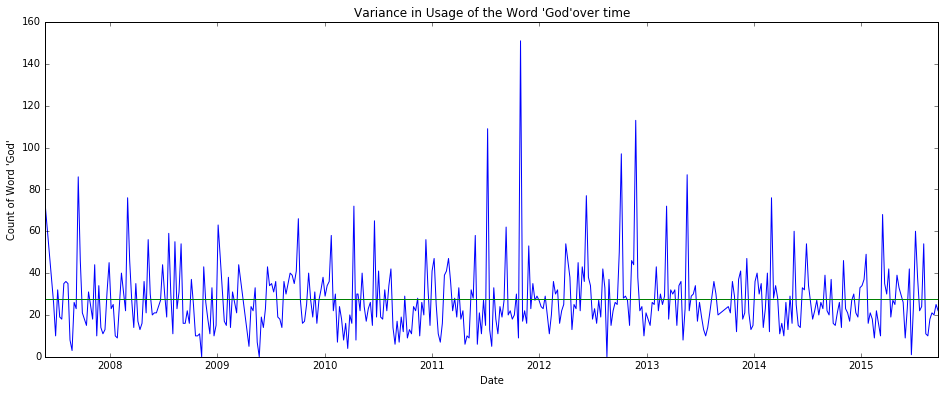

In [44]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.god)
# plt.plot(fileData.date_clean, fileData.wordcount)
plt.ylabel("Count of Word 'God'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'God'over time")
plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

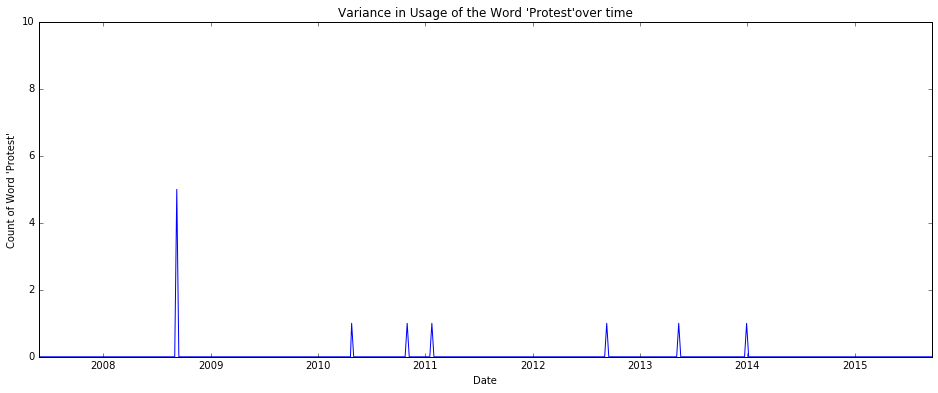

In [159]:
plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(fileData.date_clean, fileData.protest_word)
# plt.plot(fileData.date_clean, fileData.wordcount)
plt.ylabel("Count of Word 'Protest'")
plt.xlabel("Date")
plt.title("Variance in Usage of the Word 'Protest'over time")
plt.ylim([0,10])
# plt.axhline(fileData.god.mean(), color = 'green')
plt.show()

### Modeling

In [61]:
from sklearn import linear_model
from sklearn.cross_validation import train_test_split

In [62]:
X = fileData.loc[:,['wordcount','god','protest_word']]
y = fileData.protest

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [64]:
logreg = linear_model.LogisticRegression()
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)

In [65]:
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))
confmat=confusion_matrix(y_true=y_test, y_pred=y_pred, labels = [1,0])
print(confmat)

Accuracy: 0.87
[[  0  16]
 [  0 110]]


## Variable Significance Exploration

In [48]:
import statsmodels.api as sm
import pylab as pl

In [49]:
fileData.god.describe()

count    419.000000
mean      27.532220
std       16.849199
min        0.000000
25%       17.000000
50%       24.000000
75%       34.000000
max      151.000000
Name: god, dtype: float64

In [50]:
fileData.std()

protest            0.318869
wordcount       1353.265936
protest_word       0.271057
god               16.849199
dtype: float64

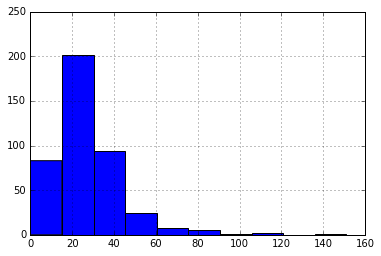

In [51]:
# plot all of the columns, Pretty Slow
fileData.god.hist()
pl.show()

In [72]:
predictor_cols = ['wordcount','god','protest_word']
# Instantiate a gamma family model with the default link function.
model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
results = model.fit()

In [73]:
len(y_train)

293

In [74]:
print results.summary()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                protest   No. Observations:                  293
Model:                            GLM   Df Residuals:                      290
Model Family:                Binomial   Df Model:                            2
Link Function:                  logit   Scale:                             1.0
Method:                          IRLS   Log-Likelihood:                -108.80
Date:                Sun, 10 Jul 2016   Deviance:                       217.60
Time:                        09:28:36   Pearson chi2:                     617.
No. Iterations:                    23                                         
                   coef    std err          z      P>|z|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------
wordcount       -0.0008      0.000     -5.666      0.000        -0.001    -0.000
god              0.0281      0.015      1.856 

In [76]:
y_preds = results.predict(X_test)

In [79]:
# Convert probabilities to Binary Response for Accuracy
y_preds10 = [1 if pred > 0.5 else 0 for pred in y_preds]

In [89]:
print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))
confmat=confusion_matrix(y_true=y_test, y_pred=y_preds10, labels = [1,0])
print(confmat)

Accuracy: 0.87
[[  0  16]
 [  0 110]]


In [94]:
# Find optimal threshold value
for k in np.arange(float(0),float(1.05),0.05):
    print 'k value: ' + str(k)
    y_preds10 = [1 if pred > k else 0 for pred in y_preds]
    print('Accuracy: %.2f' % accuracy_score(y_test,y_pred))

k value: 0.0
Accuracy: 0.87
k value: 0.05
Accuracy: 0.87
k value: 0.1
Accuracy: 0.87
k value: 0.15
Accuracy: 0.87
k value: 0.2
Accuracy: 0.87
k value: 0.25
Accuracy: 0.87
k value: 0.3
Accuracy: 0.87
k value: 0.35
Accuracy: 0.87
k value: 0.4
Accuracy: 0.87
k value: 0.45
Accuracy: 0.87
k value: 0.5
Accuracy: 0.87
k value: 0.55
Accuracy: 0.87
k value: 0.6
Accuracy: 0.87
k value: 0.65
Accuracy: 0.87
k value: 0.7
Accuracy: 0.87
k value: 0.75
Accuracy: 0.87
k value: 0.8
Accuracy: 0.87
k value: 0.85
Accuracy: 0.87
k value: 0.9
Accuracy: 0.87
k value: 0.95
Accuracy: 0.87
k value: 1.0
Accuracy: 0.87


## Undersampling Due to Class Imbalance

## Adaboost

## Find a Way to Tokenize Scripture

In [126]:
rawText=open(dataloc+files[0]).read()

In [128]:
rawText

'Sunday, May 27, 2007 page 1  Sermon Outline  "Away with such a fellow from the earth; for it is not fit that he should live." Acts 22:22. According to Friday C-J paper, some are talking about a petition demanding Phelps be ousted from Kansas. A sort of persona non grata, like they did in Canada \xad and everywhere else if they get the chance. Beloved, we\'re in good company; this is more evidence our ministry is of God and our calling and election is sure. 2 Pet. 1:10. The mob said of Paul: "Away with such a fellow from the earth; for it is not fit that he should live." Acts 22:22. Of Him Christ said: "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." Luke 19:14. "But his citizens hated him, and sent a message after him, saying, We will not have this man (Christ) to reign over us." Luke 19:14. America is a nation of sodomite pagan idolaters, worshiping a flag and worshiping the dead \xad the dunghill gods of ancient

In [129]:
import scriptures

In [131]:
# Returns a 5-tuple ('Book name', start chapter, start verse, end chapter, end verse)
scriptures.extract(rawText)

[(u'Acts', 22, 22, 22, 22),
 (u'Acts', 22, 22, 22, 22),
 (u'Luke', 19, 14, 19, 14),
 (u'Luke', 19, 14, 19, 14),
 (u'Job', 19, 26, 19, 26)]

In [132]:
import re, string

In [146]:
test = 'Job 19:26, 27'
m = re.findall('\d+:\d+', test)

In [147]:
m

['19:26']

In [145]:
m.string[m.start(test):m.end(test)]

IndexError: no such group